# The R2D2M2 Prior, the Awwwesome Linear Regression


![cover](cover.png)

There is an awesome paper that puts a simple idea of interpretable linear regression to an absolute.
The [Intuitive Joint Priors for Bayesian Linear Multilevel Models: The R2D2M2 prior](https://arxiv.org/abs/2208.07132).
The idea resonates with me a lot, since I admire interpretable priors and the ability to describe the model, not an ability to explain.

Explaining the model, you try to interpret parameters that are already present in the model, and you need to put some human-readable explanation of the meaning.
It reminds me of the top-down approach, then you introduce parameters as you need them.

Describing the model is the opposite.
You start with simple statements that you or your peers both understand.
It is usually referred to as the bottom up approach, you start with assumptions you understand and complete the model as you go.

Mastering the latter is the essence of Bayesian modeling.
In this sense, the paper is of great interest to me.

## Boston Housing Data
As a benchmark dataset, I took the Boston housing dataset.
It has the bare minimum to check the model parametrization.
I took the part of the linear regression I really need and ignored varying intercept and varying slope.
Here is the full model I'm referring to.

$$
\begin{equation}
    \begin{aligned}
y_n & \sim \mathcal{N} (\mu_n, \sigma^2) \\
\mu_n &= b_{0}+ \sum_{i=1}^p x_{ni} b_{i}+  \sum_{g\in G_0} u_{0 g_{j[n]}  }  + \sum_{i=1}^p x_{ni} \left( \sum_{g \in G_i} u_{i g_{j[n]}} \right) \\
b_{0}& \sim  p(b_{0}) \\
b_i &\sim \mathcal{N} \left(0, \frac{\sigma^2}{\sigma_{x_i}^2}   \phi_i \tau^2\right), \quad
    u_{ig_j} \sim \mathcal{N} \left(0, \frac{\sigma^2}{\sigma_{x_i}^2}   \phi_{ig} \tau^2\right) \\
    \tau^2&= \frac{R^2}{1-R^2}\\
R^2  &\sim \operatorname{Beta}(\mu_{R^2},\varphi_{R^2}), \ \
     \phi \sim \operatorname{Dirichlet} (\alpha), \ \
     \sigma \sim p(\sigma). \\
\end{aligned}
\end{equation}
$$

Let's finally get our hands dirty with code!

In [1]:
import warnings

import arviz as az
import formulae
import matplotlib.pyplot as plt
import numpy as np
import nutpie
import pymc as pm
import scipy.special as sp
import scipy.stats as st
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

In [2]:
housing = fetch_california_housing(as_frame=True)

It has to be remarked that I advocate normalizing your input data so it has $\mathbb{E}[X]=0$, $\mathbb{V}[X]=1$.
This will save you a lot of time to figure out the right scale for slope parameters.
Normalizing the output variable also makes a lot of sense.
You may also notice that it is actually a part of the R2D2M2 linear regression parameterization.
A rule of thumb is to take care of it one way or another.

$$
b_i \sim \mathcal{N} \left(0, \frac{\sigma^2}{\sigma_{x_i}^2}\right)
$$

In [3]:
Xscaler = StandardScaler()

We deal with positive outcome, prices. 
I would also expect the variable effect to have elasticity interpretation. 
To do so, I apply `log` transformation on positive valued regressors.

In [4]:
data = housing["data"].copy()
target = housing["target"]
non_negative_variables = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
]
data[non_negative_variables] = np.log1p(data[non_negative_variables])
target = np.log(target)

In [5]:
X = Xscaler.fit_transform(data)
mean = target.mean()
std = target.std()

### Non-centered R2D2M2
Whenever I see a normal distribution with mean and scale, I tend to use non-centered parameterization.
I was shocked to see how different it is from the centered case.
But before we go to the working examples, let's see how to make an amazing model miserably fail.

In [6]:
# grade the importance of variables
# 0 - least important, inf - most important
# 1 - "I do not know"
alpha = np.ones(X.shape[1])
# Give me the 95% bounds of possible R2 for this linear regression
# 0 - I do not believe in this makes any sense
# 1 - I totally believe data perfectly explains the outcome
R2 = (0.7, 0.9)

In [7]:
with pm.Model(coords=dict(variable=data.columns)) as model_sigma_detached:
    R2p = pm.find_constrained_prior(pm.Beta, *R2, init_guess=dict(alpha=1, beta=1))
    r2 = pm.Beta("R2", **R2p)
    # the global R2
    tau2 = r2 / (1 - r2)
    # Local R2 / variable importance
    phi = pm.Dirichlet("phi", alpha, dims="variable")
    # Non-Centered parametrization
    # Note that we scale the parameters by output std
    beta = pm.Normal("coef_raw", dims="variable") * std * (phi * tau2) ** 0.5
    beta = pm.Deterministic("coef_norm", beta, dims="variable")
    # Parameters on the original data scale
    pm.Deterministic("coef", beta / Xscaler.scale_, dims="variable")
    # now the likelihood
    # NOTE: sigma is detached from R2
    sigma = pm.HalfNormal("sigma", std)
    intercept = pm.StudentT("intercept", 3, mean, sigma=std / 4)
    estimate = X @ beta + intercept
    nu = pm.Gamma("nu", mu=20, sigma=3)
    pm.StudentT("obs", nu, mu=estimate, sigma=sigma, observed=target)

In [8]:
with model_sigma_detached:
    prior = pm.sample_prior_predictive()

Sampling: [R2, coef_raw, intercept, nu, obs, phi, sigma]


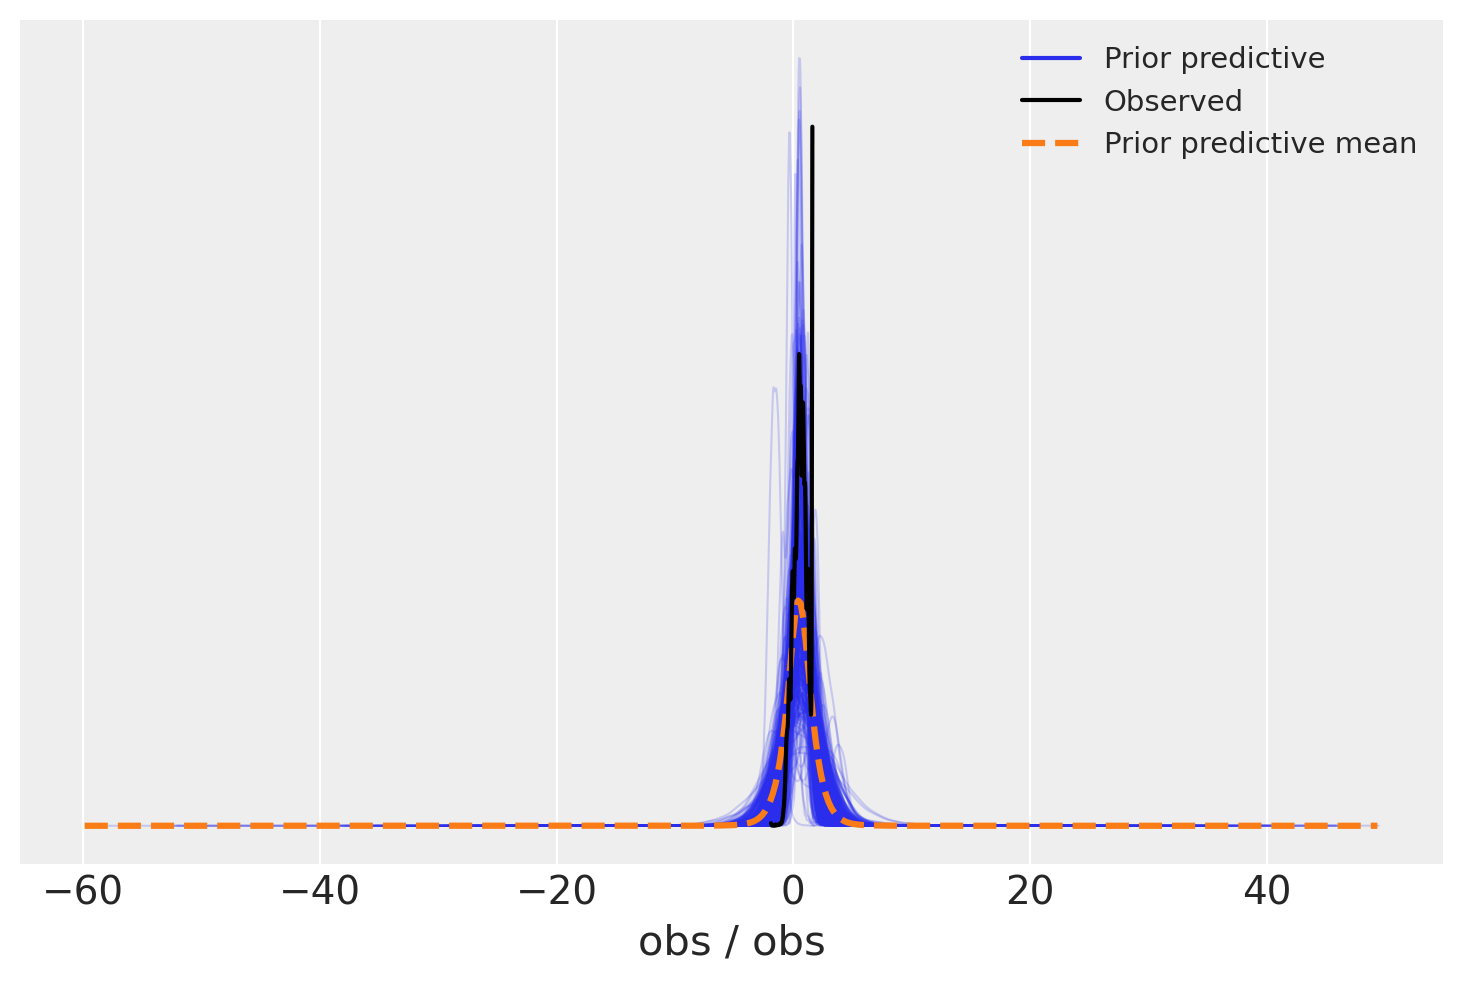

In [10]:
az.plot_ppc(prior, group="prior");

In [11]:
model_sigma_detached.point_logps()

{'R2': 0.16,
 'phi': -6.03,
 'coef_raw': -7.35,
 'sigma': -0.73,
 'intercept': 0.95,
 'nu': 0.98,
 'obs': -17806.69}

In [13]:
with model_sigma_detached:
    trace = pm.sample(nuts_sampler="nutpie")
    trace.extend(prior)

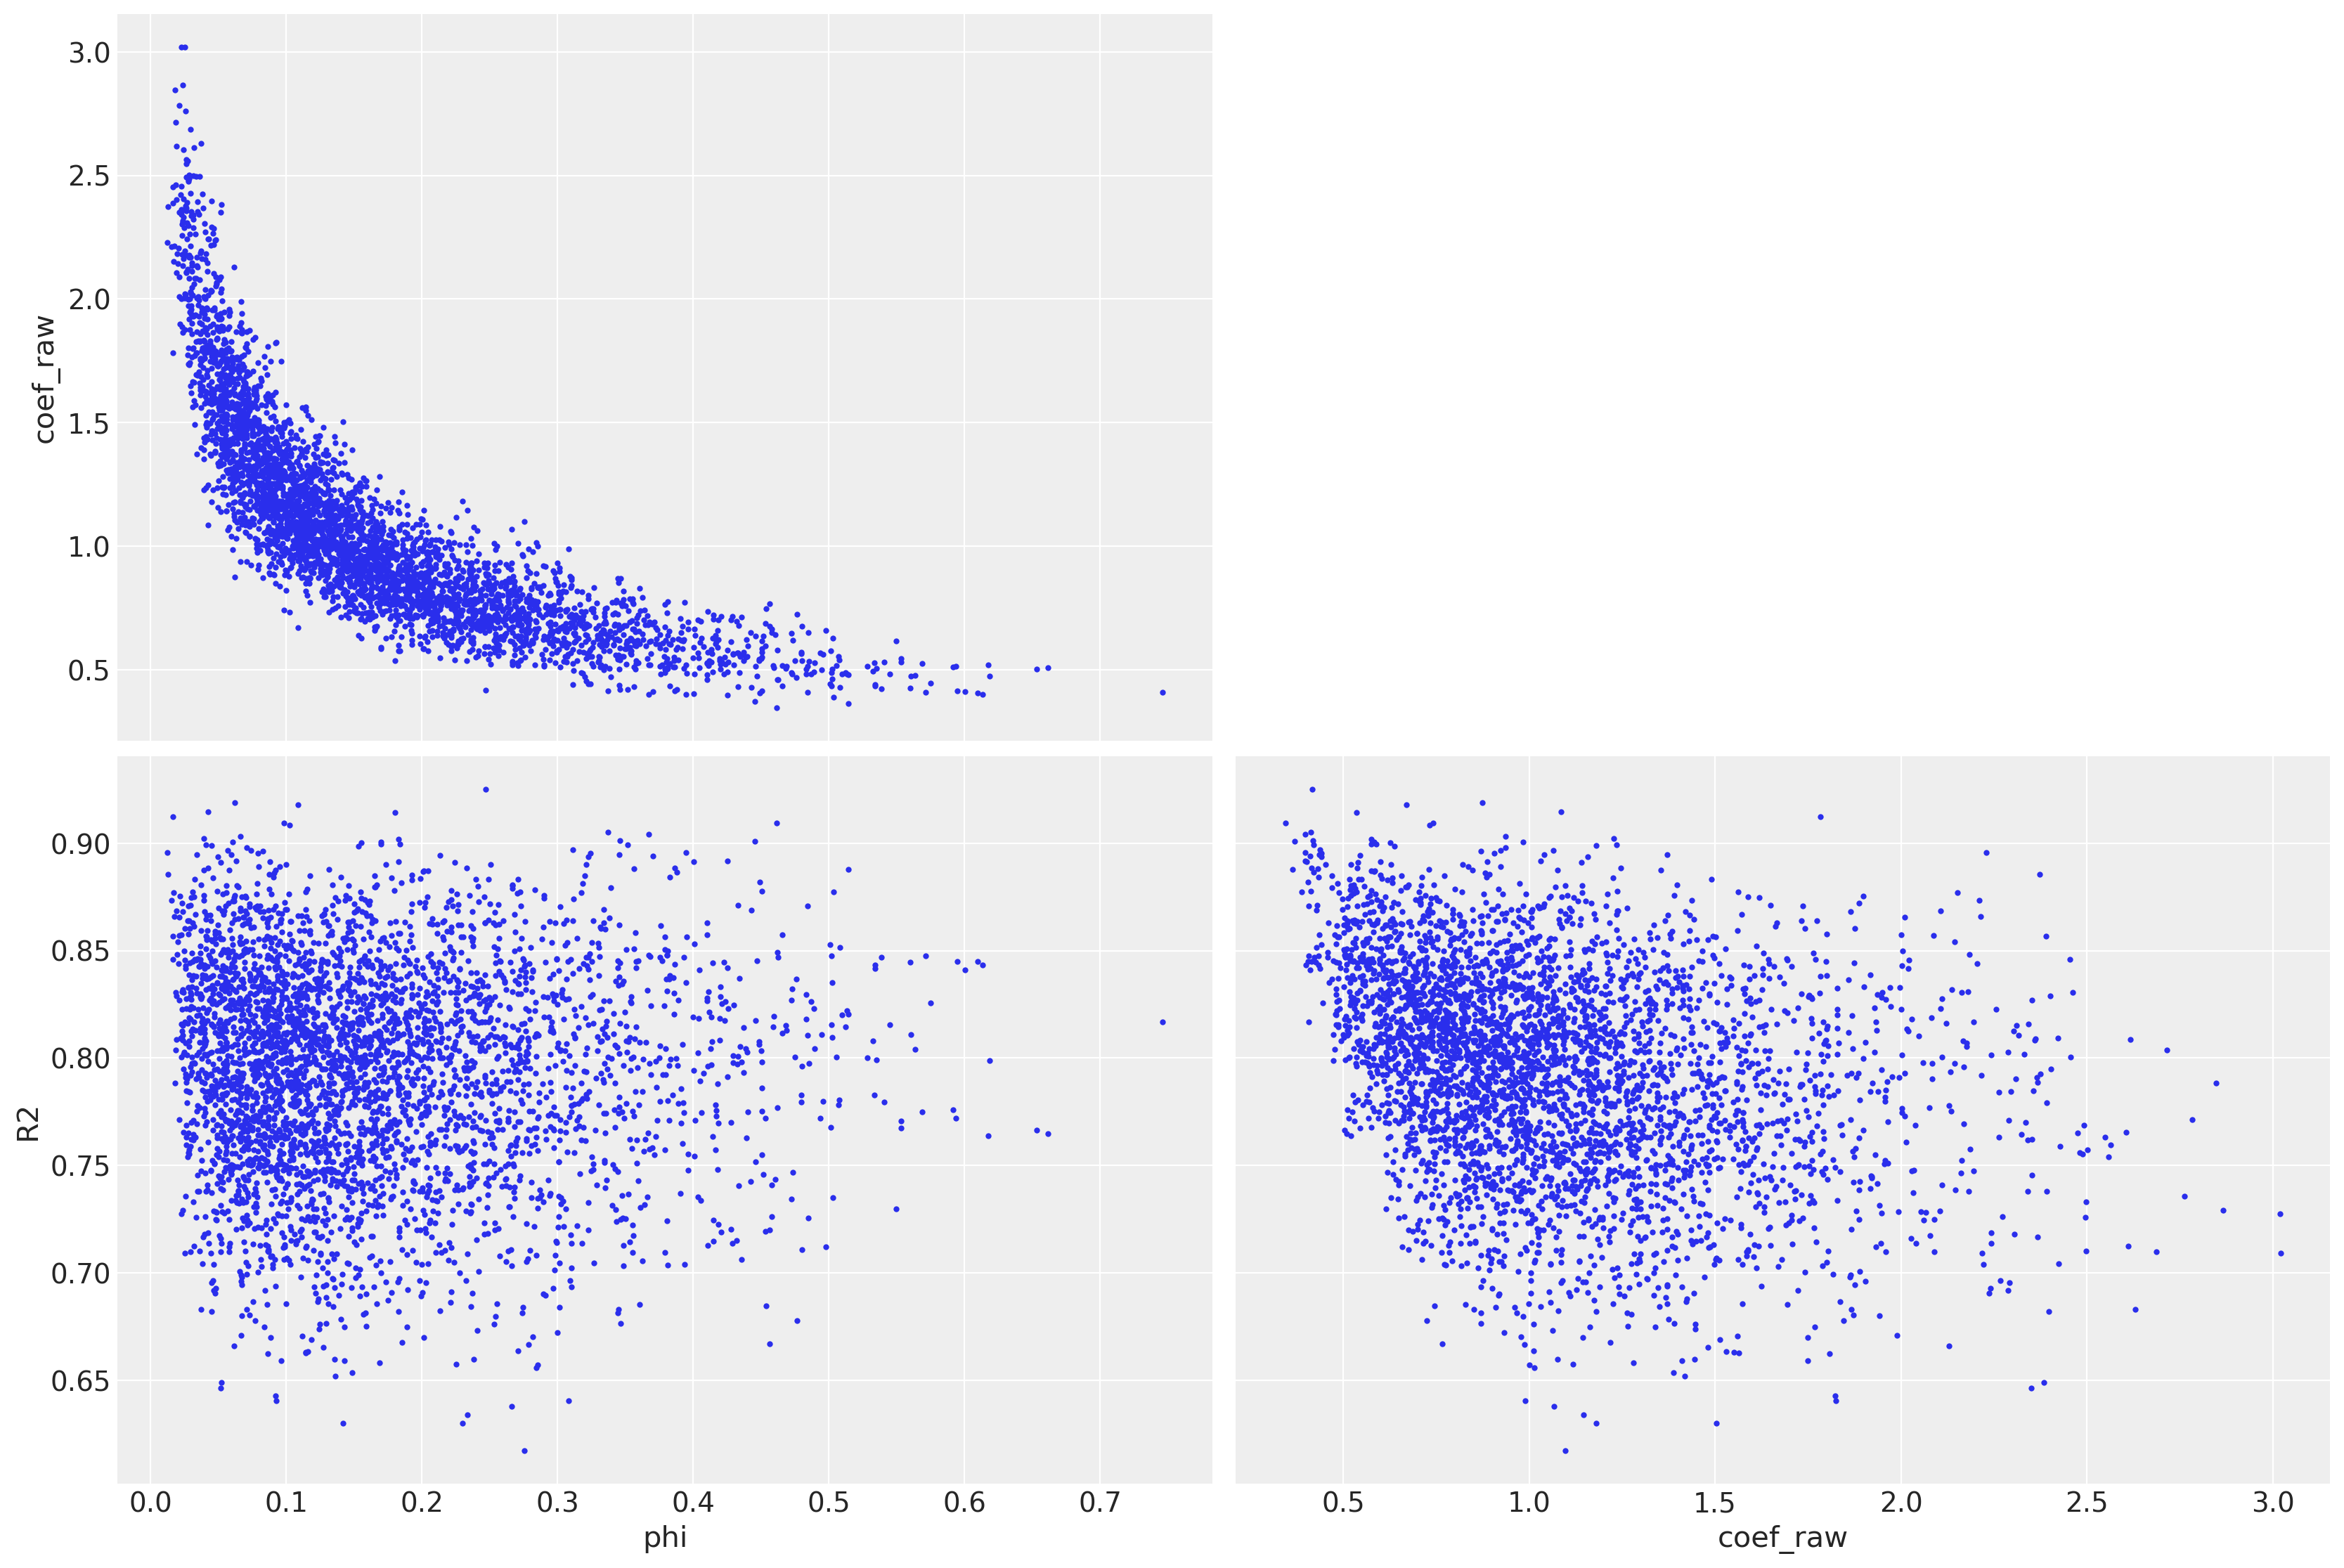

In [14]:
az.plot_pair(trace, var_names=["phi", "coef_raw", "R2"], coords=dict(variable="MedInc"));

Yet it has no divergences, the parameter landscape is very complicated.

* Larger phi discourages large coefficients.
* There is also a banana shape relationship
* Step size should be very different if you are in the center of the banana or on its boundary.
* Total sampling time on my Supermicro is almost 1 hour 🤯

### Centered R2D2M2
To my surprise, this model parametrization is 20 times faster than a non-centered variant.
Once you download the notebook, you can play around with some parameters below to get the idea of R2D2M2 strong or weak places.
Here is the bare minimum of what you should know about the model:

* You choose R2:
    * In econometrics classes, you've seen what is R2. 
    * 1 - is a perfect data fit
    * 0 - total noise and predictors are irrelevant.
    * In a Bayesian setup, you do not pick one, you pick possible ones.
    * A suggestion is to pick a $95\%$ range $(R^2_{2.5\%}, R^2_{97.5\%})$.
* You choose variable importance:
    * There are usually many variables in the regression, one you might assume is more important than another.
    * $\alpha_i$ is the parameter to look into to express the knowledge.
    * $\alpha_i=1$ is total unawareness of the importance of the variable.
    * $\alpha_i<1$ tells the model you tend to think the $i$'th variable is likely to be not significant.
    * $\alpha_i>1$ informs your model not to ignore the variable.
    * Extremely large or small $\alpha_i$ may cause numerical problems or divergences
        * 0.001 was too small
        * 200 was too much
        * You can explore better reasonable bounds using this notebook


In [8]:
def create_non_centered_model_1(
    n_irrelevant=0,
    # grade the importance of variables
    # 0 - least impotant, inf - most important
    # 1 - "I do not know"
    useful_variables_alpha=2,
    wasted_variables_alpha=0.5,
):
    # set irrelevant variables
    Xr = np.concatenate([X, np.random.randn(X.shape[0], n_irrelevant)], -1)
    cols = np.concatenate([data.columns, list(map(str, range(n_irrelevant)))])
    scaling = np.concatenate([Xscaler.scale_, np.ones(n_irrelevant)])

    alpha = np.concatenate(
        [
            np.full(X.shape[1], useful_variables_alpha),
            np.full(n_irrelevant, wasted_variables_alpha),
        ]
    )
    # Give me the 95% bounds of possible R2 for this linear regression
    # 0 - I do not believe in this makes any sense
    # 1 - I totally believe data perfectly explains the outcome
    R2 = (0.7, 0.9)

    with pm.Model(coords=dict(variable=cols)) as model_centered_sigma_detached:
        R2p = pm.find_constrained_prior(pm.Beta, *R2, init_guess=dict(alpha=1, beta=1))
        r2 = pm.Beta("R2", **R2p)
        tau2 = (r2 / (1 - r2)) ** 0.5
        phi = pm.Dirichlet("phi", alpha, dims="variable")
        beta = pm.Deterministic(
            "coef_norm",
            pm.Normal("coef_raw", 0, (phi * tau2) ** 0.5, dims="variable") * std,
            dims="variable",
        )
        pm.Deterministic("coef", beta / scaling, dims="variable")
        sigma = pm.HalfNormal("sigma", std)
        intercept = pm.StudentT("intercept", 3, mean, sigma=std / 4)
        estimate = Xr @ beta + intercept
        nu = pm.Gamma("nu", mu=20, sigma=3)
        pm.StudentT("obs", nu, estimate, sigma=sigma, observed=target)
    return model_centered_sigma_detached

In [46]:
with create_non_centered_model_1() as model_centered_sigma_detached:
    trace1 = pm.sample(nuts_sampler="nutpie")

#### Combining residual and sigma

Sampling is much faster but there are divergences. Let's try to combine $R^2$ and $\sigma$

In [10]:
def create_non_centered_model_2(
    n_irrelevant=0,
    # grade the importance of variables
    # 0 - least impotant, inf - most important
    # 1 - "I do not know"
    useful_variables_alpha=2,
    wasted_variables_alpha=0.5,
):
    # set irrelevant variables
    Xr = np.concatenate([X, np.random.randn(X.shape[0], n_irrelevant)], -1)
    cols = np.concatenate([data.columns, list(map(str, range(n_irrelevant)))])
    scaling = np.concatenate([Xscaler.scale_, np.ones(n_irrelevant)])

    alpha = np.concatenate(
        [
            np.full(X.shape[1], useful_variables_alpha),
            np.full(n_irrelevant, wasted_variables_alpha),
        ]
    )
    with pm.Model(coords=dict(variable=cols)) as model_sigma_attached:
        R2p = pm.find_constrained_prior(pm.Beta, *R2, init_guess=dict(alpha=1, beta=1))
        r2 = pm.Beta("R2", **R2p)
        # interpreted as total variance now
        # it is concentrated around empirical variance
        sigma = pm.LogNormal("sigma", np.log(std), 0.1)
        # the global R2
        tau2 = r2 / (1 - r2)
        # Local R2 / variable importance
        phi = pm.Dirichlet("phi", alpha, dims="variable")
        # Centered parametrization
        # Note that we scale the parameters by output std
        beta = pm.Normal("coef_raw", 1, sigma * (phi * tau2) ** 0.5, dims="variable")
        beta = pm.Deterministic("coef_norm", beta, dims="variable")
        # Parameters on the original data scale
        pm.Deterministic("coef", beta / scaling, dims="variable")
        # now the likelihood
        resid_sigma = (1 - r2) ** 0.5 * sigma
        intercept = pm.StudentT("intercept", 3, mean, sigma=std / 4)
        estimate = Xr @ beta + intercept
        nu = pm.Gamma("nu", mu=20, sigma=3)
        pm.StudentT("obs", nu, mu=estimate, sigma=resid_sigma, observed=target)
    return model_sigma_attached

In [19]:
with create_non_centered_model_2() as model_sigma_attached:
    trace2 = pm.sample(nuts_sampler="nutpie")

Yet, there is correlation in sigma and $R^2$

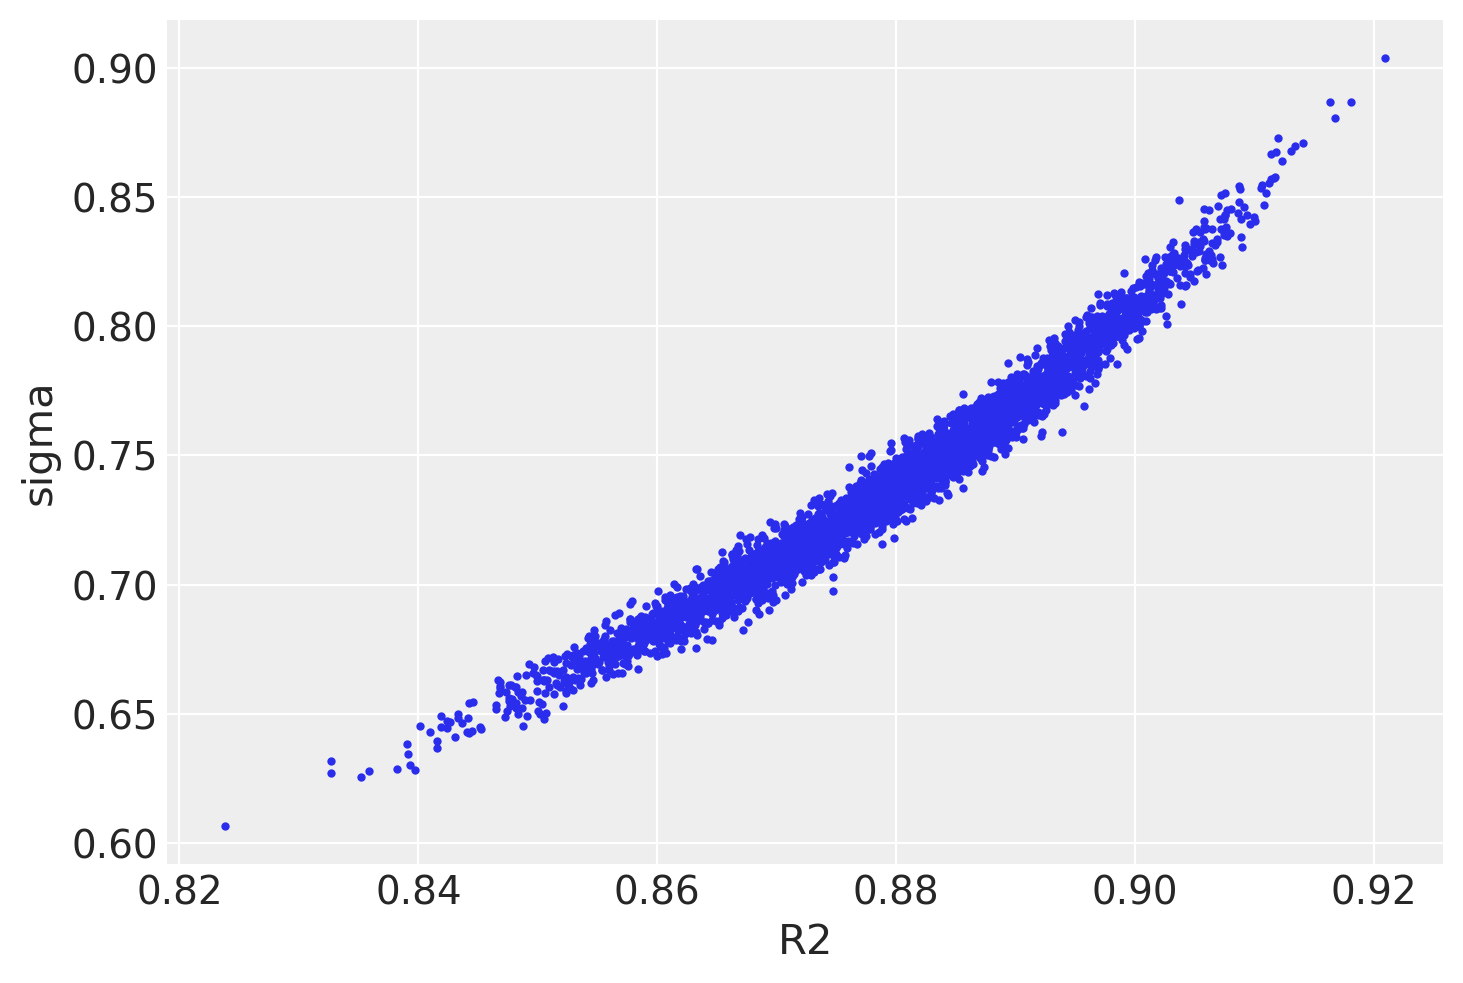

In [13]:
az.plot_pair(
    trace2,
    var_names=["R2", "sigma"],
    coords=dict(variable="MedInc"),
    divergences=True,
);

What did the job was:

1) Centered parametrization

```python
beta = pm.Normal("coef_raw", 1, sigma * (phi * tau2) ** 0.5, dims="variable")
```

2) Attaching residual sigma to the model and $R^2$ parametrization

```python
sigma = pm.LogNormal("sigma", np.log(std), 0.1)
...
resid_sigma = (1 - r2) ** 0.5 * sigma
```

### Sparse solution
Now imagine we have some doubtful variables under consideration. We are unsure we should use them, but some of them may be helpful. To create a model under this setting, we need variable importance which are $\alpha$ in the model parameterization.

In [40]:
with create_non_centered_model_2(
    n_irrelevant=10,
    wasted_variables_alpha=0.5,
    useful_variables_alpha=2,
) as model_sigma_attached_10:
    trace3 = pm.sample(nuts_sampler="nutpie")

The amount of sparsity is incredible. Yet, there are divergences which are an adventure to investigate.

As authors claim, there are instabilities with low $\alpha$, and general recommendation (personal experience) is to exclude non-informative variables and set variable importance $\alpha$ > 1

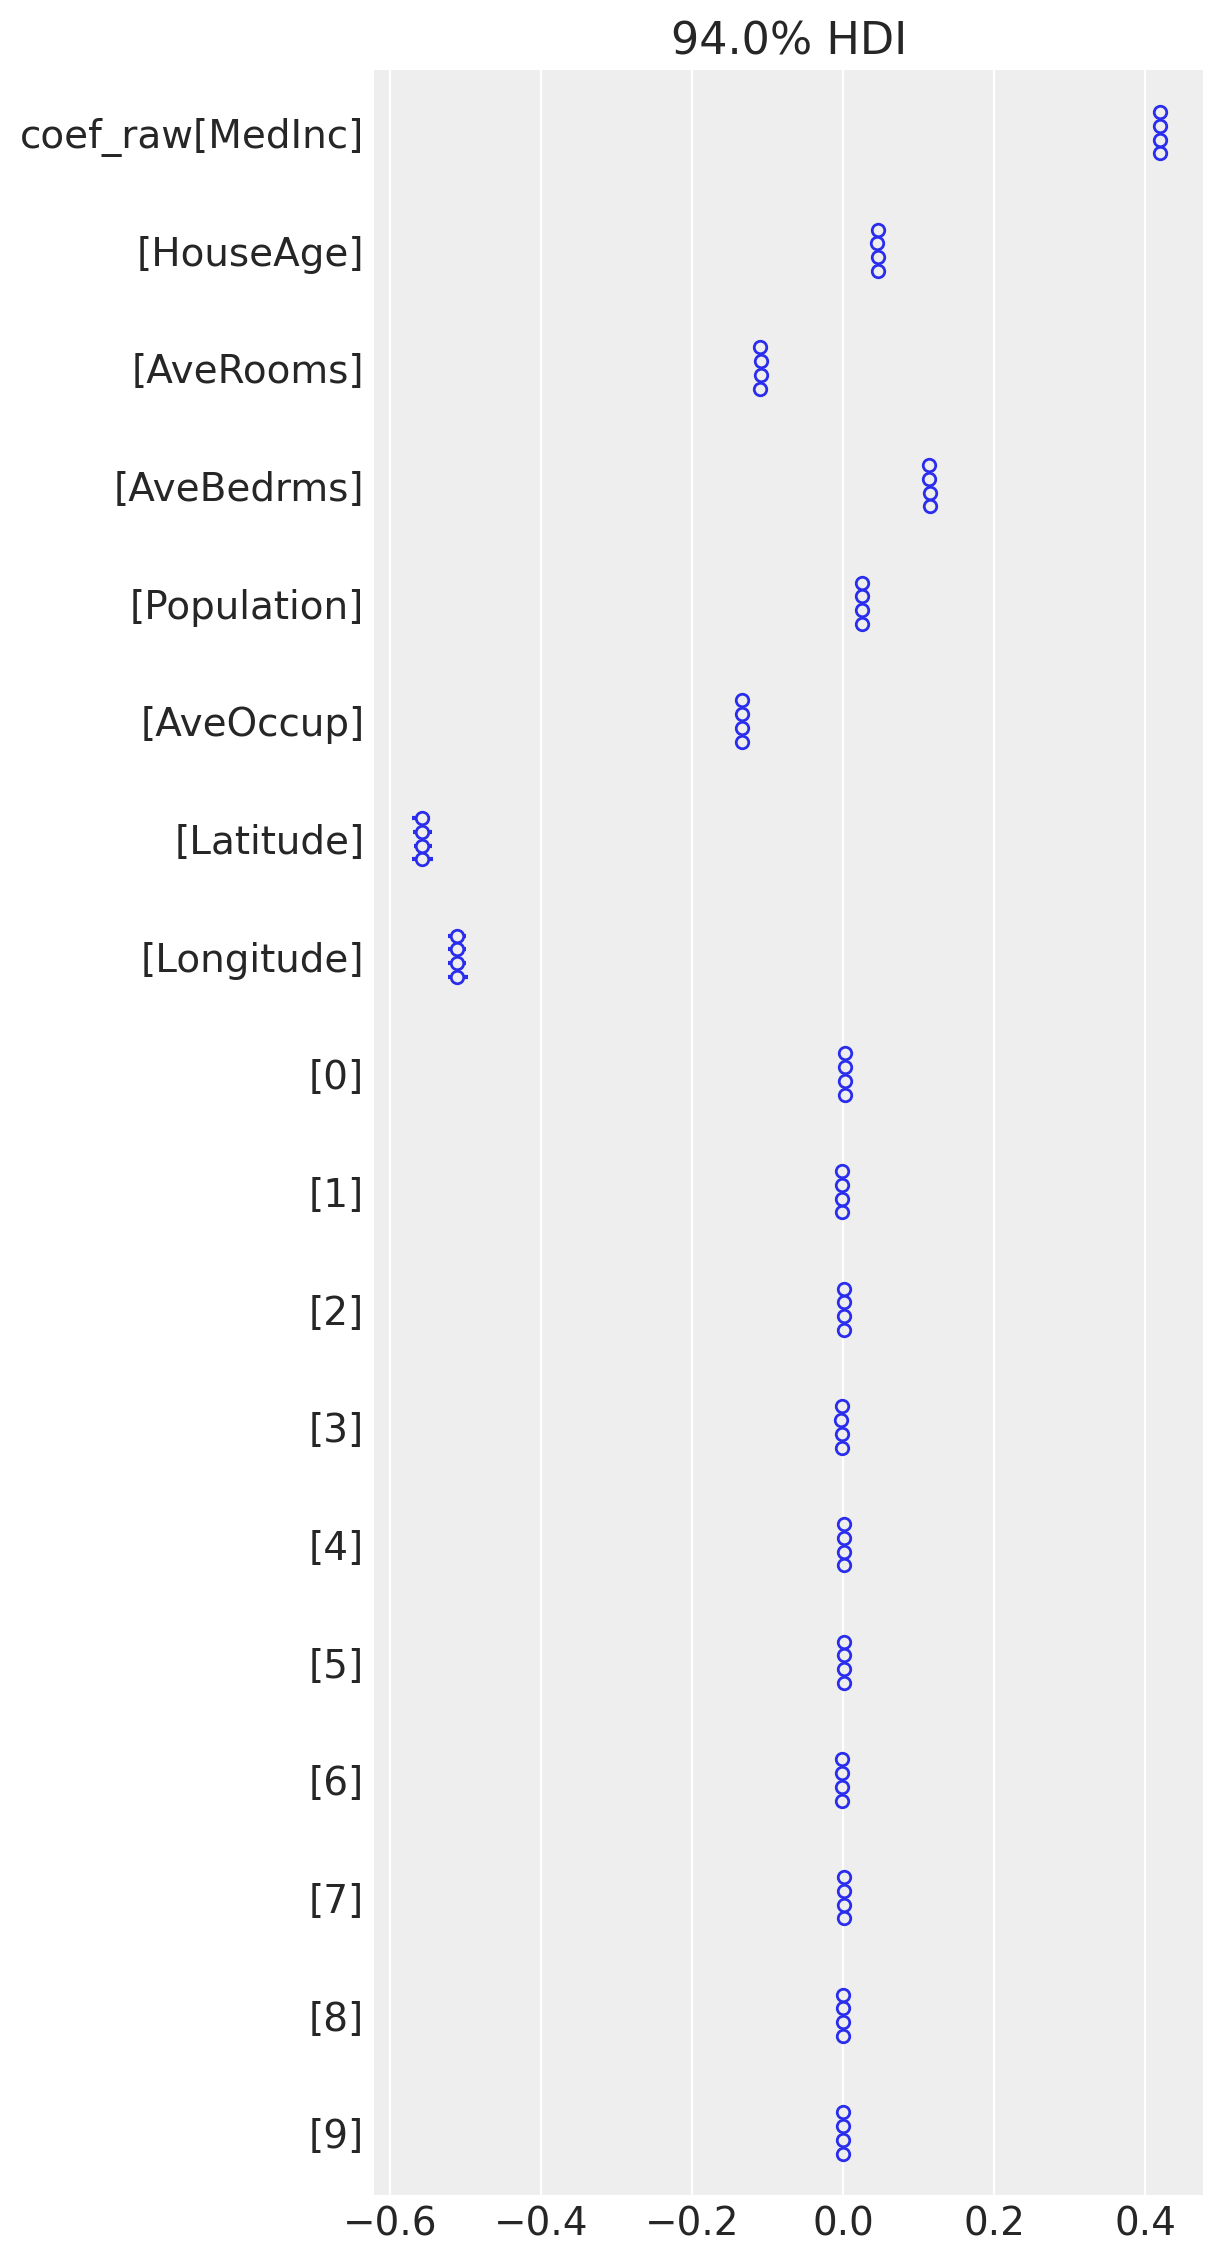

In [41]:
az.plot_forest(trace3, var_names=["coef_raw"], combined=False)
plt.tight_layout();

## Conclusion

There are few practical advices to use R2D2M2 prior:

- Use the prior to weight variables that make sense. The sparsity inducing alpha leads to instabilities (which you may ignore).
- Not always centered parametrization was great in my applications. I recommend trying both.
- Coupling the error term sigma into the model leads to fewer instabilities and more interpretable sigma prior.